# McStas data to MJOLNIR data format, conversion script for BIFROST

by: Kristine M. L. Krighaar

created: 18/01/2024

In [1]:
from KGS import * # Utilizing my own package for data analysis. Remember to also send enviroment when sharing. 
import scipp as sc
from TubeMeasurment_mccode import BIFROST_measurement


## Data reduction process

Full overview of how converison is done: 

## Exporting dataformat for as .txt MJOLNIR

In [2]:
#BIFROST_measurement.load_scan('vana_norm_1t','Incoherent_0mev_data_corrected',set_Elim=(-1,7), Correct=True)

# DATA TREATMENT FOR INCOHERENT

In [3]:
settings = np.loadtxt('Incoherent_5mev_data_corrected').T

## plotting Intensities to see distribution! 

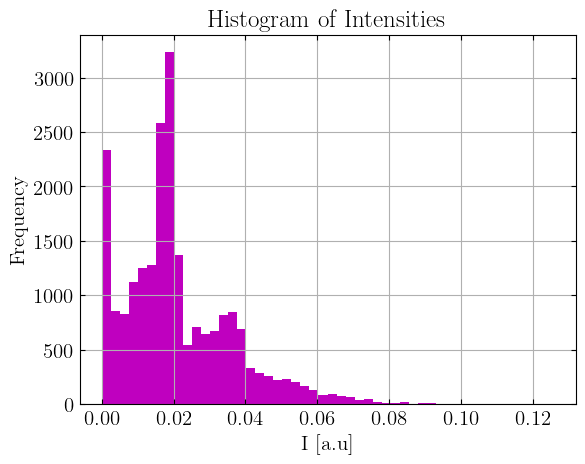

In [4]:
data_flat = settings[0]

# Create a histogram
plt.hist(data_flat[(data_flat>0.0001)], bins=50, color='m')  # Adjust the number of bins as needed
plt.xlabel('I [a.u]')
plt.ylabel('Frequency')
plt.title('Histogram of Intensities')
plt.grid(True)
plt.show()



In [5]:

"""
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot data: I, I_err, DeltaE, qx, qy
ax.scatter(settings[3], settings[4], settings[2], c=settings[0])

ax.set_xlabel('qx')
ax.set_ylabel('qy')
ax.set_zlabel('DeltaE')
ax.set_title('tube measuring surface')
plt.show()
"""

"\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\n\n# Plot data: I, I_err, DeltaE, qx, qy\nax.scatter(settings[3], settings[4], settings[2], c=settings[0])\n\nax.set_xlabel('qx')\nax.set_ylabel('qy')\nax.set_zlabel('DeltaE')\nax.set_title('tube measuring surface')\nplt.show()\n"

# 1 tube 5 meV

In [15]:


settings = np.loadtxt('Incoherent_5mev_data_corrected').T

qx = sc.array(dims=["row"], values=settings[3], unit="Å^(-1)")
qy = sc.array(dims=["row"], values=settings[4], unit="Å^(-1)")
deltaE = sc.array(dims=["row"], values=settings[2], unit="meV")
Q = sc.array(dims=["row"], values=np.sqrt(settings[3]**2+settings[4]**2), unit="Å^(-1)")

recording = sc.DataArray(
    data=sc.array(dims=["row"], values=settings[0], unit="arb. units", variances=settings[1]),  #, variances=settings[1]
    coords={"qx": qx, "qy": qy, "deltaE":deltaE, "Q":Q}
)

sliced = recording.bin(qx=400, qy=400, deltaE=300)
slicedQ = recording.bin(deltaE=170, Q=120)

#sliced = sliced.bins
#sliced

slicedQ = slicedQ.hist()
slicedQ


<scipp.DataArray>
Dimensions: Sizes[deltaE:170, Q:120, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.712206, 0.734719, ..., 3.39126, 3.41378]
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [-0.999998, -0.95294, ..., 6.9528, 6.99985]
Data:
                            float64      [arb. unit]  (deltaE, Q)  [0, 0, ..., 0, 0]  [0, 0, ..., 0, 0]

## Data treatment

In [18]:
E_min = 4.5 * sc.Unit('meV')
E_max = 5.5 * sc.Unit('meV')

Q_min = 1.2 * sc.Unit('Å^(-1)')
Q_max = 3 * sc.Unit('Å^(-1)')


p3 = slicedQ['Q',Q_min:Q_max]['deltaE', E_min:E_max]
p4 = sc.mean(p3, dim='Q')

# Gauss fit for line
deltaE = p4.coords['deltaE'].values
deltaE  = (deltaE[:-1] + deltaE[1:]) / 2.0
I = np.nan_to_num(p4.values, nan=0)

def in_line(x, A, mu, sigma):
    return gauss(x, A, mu, sigma)#+b


guess = {'A':0.3, 'mu':5.0, 'sigma':0.08}
lim = {'A':(0.01, 0.6)}
in_fit = fit(deltaE, p4.values, p4.variances, in_line, guess)

mu = np.average(deltaE, weights=I)
FWHM = np.sqrt(np.average((deltaE-mu)**2, weights=I))*2.3548
print(mu)
print(FWHM)
print(in_fit.values[2]*2.35)

in_fit.hesse()

5.004350233765176
0.15753228228087676
0.12925894486334383


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.108e+04                  │              Nfcn = 219              │
│ EDM = 5.26e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │   1.513   │   0.007   │            │            │         │         │       │
│ 1 │ mu    │  5.01593  │  0.00012  │            │            │         │         │       │
│ 2 │ sigma │ 55.00e-3  │  0.04e-3  │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         A        mu     sigma │
├───────┼───────────────────────────────┤
│     A │  5.51e-05 -2.17e-07 -1.98e-07 │
│    mu │ -2.17e-07  1.44e-08  2.25e-09 │
│ sigma │ -1.98e-07  2.25e-09  1.89e-09 │
└───────┴───────────────────────────────┘

## Plotting

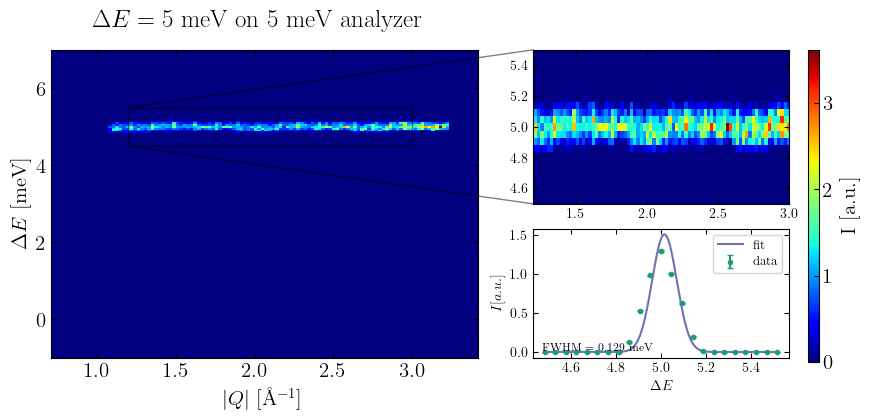

In [19]:
E_min = -2 * sc.Unit('meV')
E_max = 10 * sc.Unit('meV')

Q_min = 0 * sc.Unit('Å^(-1)')
Q_max = 3.5 * sc.Unit('Å^(-1)')


fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))

p5 = slicedQ['Q',Q_min:Q_max]['deltaE', E_min:E_max]

im = ax.pcolormesh(p5.coords['Q'].values, p5.coords['deltaE'].values, p5.values, cmap='jet')
ax.set_ylabel(r'$\Delta E$ [meV]')
ax.set_xlabel(r'$|Q|$ [Å$^{-1}$]')

# inset axes....
x1, x2, y1, y2 = 1.2, 3, 4.5, 5.5  # subregion of the original image
axins = ax.inset_axes(
    [1.13, 0.5, 0.6, 0.5],
    transform=ax.transAxes,
    xlim=(x1, x2), ylim=(y1, y2))
axins.pcolormesh(p3.coords['Q'].values, p3.coords['deltaE'].values, p3.values, cmap='jet')
axins.tick_params(axis='both', which='major', labelsize=10)

# Draw a rectangle to mark the region of the original plot that is shown in the inset
ax.indicate_inset_zoom(axins, edgecolor="black")


x_range = np.linspace(min(deltaE), max(deltaE),1000)
axins2 = ax.inset_axes([1.13, 0.0, 0.6, 0.42])
axins2.errorbar(deltaE, p4.values, p4.variances, fmt='.', label='data')
axins2.plot(x_range, in_line(x_range, *in_fit.values), label='fit')
axins2.tick_params(axis='both', which='major', labelsize=10)
axins2.legend(fontsize=9)

axins2.text(4.47, 0.02, f'FWHM = {in_fit.values[2]*2.35:.3f} meV', fontsize=8)

axins2.set_xlabel('$\Delta E$', fontsize=10)
axins2.set_ylabel('$I [a.u.]$', fontsize=10)

caxes = fig.add_axes([1.5, 0.1, 0.02, 0.78])
cbar = plt.colorbar(im, cax=caxes)
cbar.set_label('I [a.u.]')

fig.suptitle('$\Delta E = 5$ meV on 5 meV analyzer')

plt.savefig('Incoherent_5mev_corrected.pdf', format='pdf', bbox_inches='tight')
plt.show()

# 1 tube 2.7 meV

In [9]:
tube_2p7 = np.loadtxt('Incoherent_0mev_data_corrected').T

qx_2p7 = sc.array(dims=["row"], values=tube_2p7[3], unit="Å^(-1)")
qy_2p7 = sc.array(dims=["row"], values=tube_2p7[4], unit="Å^(-1)")
deltaE_2p7 = sc.array(dims=["row"], values=tube_2p7[2], unit="meV")
Q_2p7 = sc.array(dims=["row"], values=np.sqrt(tube_2p7[3]**2+tube_2p7[4]**2), unit="Å^(-1)")

recording_2p7 = sc.DataArray(
    data=sc.array(dims=["row"], values=tube_2p7[0], unit="arb. units", variances=tube_2p7[1]),  #, variances=settings[1]
    coords={"qx": qx_2p7, "qy": qy_2p7, "deltaE":deltaE_2p7, "Q":Q_2p7}
)
slicedQ_2p7 = recording_2p7.bin(deltaE=350, Q=120)

slicedQ_2p7 = slicedQ_2p7.bins.mean()
slicedQ_2p7

<scipp.DataArray>
Dimensions: Sizes[deltaE:350, Q:120, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [1.63798, 1.65671, ..., 3.86694, 3.88567]
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [-0.999998, -0.977141, ..., 6.977, 6.99985]
Data:
                            float64      [arb. unit]  (deltaE, Q)  [0, 0, ..., nan, nan]  [0, 0, ..., nan, nan]

In [10]:
E_min = -0.5 * sc.Unit('meV')
E_max = 0.5 * sc.Unit('meV')

Q_min = 1.8 * sc.Unit('Å^(-1)')
Q_max = 2.83 * sc.Unit('Å^(-1)')


p3_2p7 = slicedQ_2p7['Q',Q_min:Q_max]['deltaE', E_min:E_max]
p4_2p7 = sc.mean(p3_2p7, dim='Q')

# Gauss fit for line
deltaE_2p7 = p4_2p7.coords['deltaE'].values
deltaE_2p7  = (deltaE_2p7[:-1] + deltaE_2p7[1:]) / 2.0
I_2p7 = np.nan_to_num(p4_2p7.values, nan=0)

def in_line(x, A, mu, sigma):
    return gauss(x, A, mu, sigma)


guess_2p7 = {'A':0.03, 'mu':0.001, 'sigma':0.02}
lim_2p7 = {'A': (0.01,0.5)}
in_fit_2p7 = fit(deltaE_2p7, p4_2p7.values, p4_2p7.variances, in_line, guess_2p7)

mu_2p7 = np.average(deltaE_2p7, weights=I_2p7)
FWHM_2p7 = np.sqrt(np.average((deltaE_2p7-mu_2p7)**2, weights=I_2p7))*2.3548
print(mu_2p7)
print(FWHM_2p7)
print(in_fit_2p7.values[2]*2.3548)


in_fit_2p7.hesse()



-0.007872082816196979
0.08744760944956538
0.08241515556777396


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.14e+07                   │              Nfcn = 118              │
│ EDM = 7.15e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │36.6781e-3 │ 0.0024e-3 │            │            │         │         │       │
│ 1 │ mu    │-6.3032e-3 │ 0.0012e-3 │            │            │         │         │       │
│ 2 │ sigma │34.9988e-3 │ 0.0007e-3 │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         A        mu     sigma │
├───────┼───────────────────────────────┤
│     A │  5.99e-12 -1.97e-13 -1.03e-12 │
│    mu │ -1.97e-13  1.53e-12  1.09e-13 │
│ sigma │ -1.03e-12  1.09e-13  4.45e-13 │
└───────┴───────────────────────────────┘

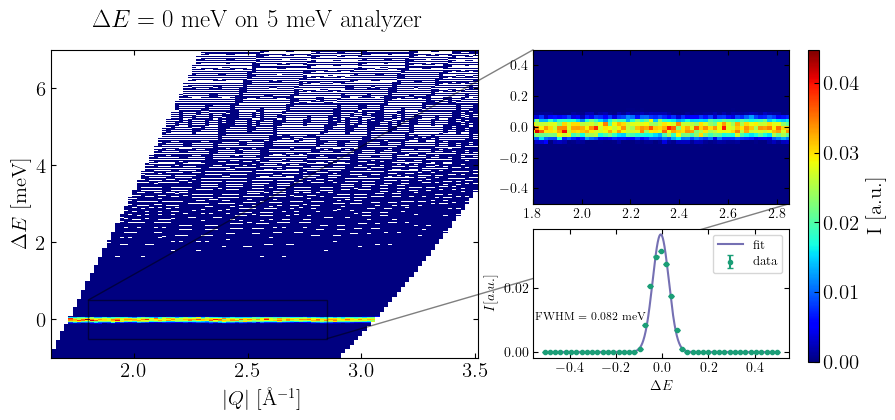

In [11]:
E_min = -2 * sc.Unit('meV')
E_max = 10 * sc.Unit('meV')

Q_min = 0 * sc.Unit('Å^(-1)')
Q_max = 3.5 * sc.Unit('Å^(-1)')


fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))

p_2p7 = slicedQ_2p7['Q',Q_min:Q_max]['deltaE', E_min:E_max]

im = ax.pcolormesh(p_2p7.coords['Q'].values, p_2p7.coords['deltaE'].values, p_2p7.values, cmap='jet')
ax.set_ylabel(r'$\Delta E$ [meV]')
ax.set_xlabel(r'$|Q|$ [Å$^{-1}$]')

# inset axes....
x1, x2, y1, y2 = 1.8, 2.85, -0.5, 0.5  # subregion of the original image
axins = ax.inset_axes(
    [1.13, 0.5, 0.6, 0.5],
    transform=ax.transAxes,
    xlim=(x1, x2), ylim=(y1, y2))
axins.pcolormesh(p_2p7.coords['Q'].values, p_2p7.coords['deltaE'].values, p_2p7.values, cmap='jet')
axins.tick_params(axis='both', which='major', labelsize=10)

# Draw a rectangle to mark the region of the original plot that is shown in the inset
ax.indicate_inset_zoom(axins, edgecolor="black")


x_range_2p7 = np.linspace(min(deltaE_2p7), max(deltaE_2p7),1000)
axins2 = ax.inset_axes([1.13, 0.0, 0.6, 0.42])
axins2.errorbar(deltaE_2p7, p4_2p7.values, p4_2p7.variances, fmt='.', label='data')
axins2.plot(x_range_2p7, in_line(x_range_2p7, *in_fit_2p7.values), label='fit')
axins2.tick_params(axis='both', which='major', labelsize=10)
axins2.legend(fontsize=9)

axins2.text(-0.55, 0.01, f'FWHM = {in_fit_2p7.values[2]*2.35:.3f} meV', fontsize=8)

axins2.set_xlabel('$\Delta E$', fontsize=10)
axins2.set_ylabel('$I [a.u.]$', fontsize=10)

caxes = fig.add_axes([1.5, 0.1, 0.02, 0.78])
cbar = plt.colorbar(im, cax=caxes)
cbar.set_label('I [a.u.]')

fig.suptitle('$\Delta E = 0$ meV on 5 meV analyzer')

plt.savefig('Incoherent_0mev_corrected.pdf', format='pdf', bbox_inches='tight')
plt.show()